
[Fold 1] 정확도: 0.5536, Macro F1: 0.5479
              precision    recall  f1-score   support

           0     0.7908    0.4816    0.5987     31943
           1     0.3811    0.7147    0.4971     14264

    accuracy                         0.5536     46207
   macro avg     0.5859    0.5982    0.5479     46207
weighted avg     0.6643    0.5536    0.5673     46207



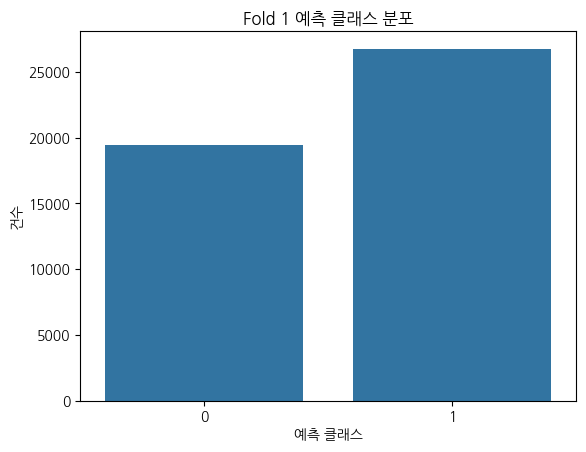


[Fold 2] 정확도: 0.5547, Macro F1: 0.5474
              precision    recall  f1-score   support

           0     0.7840    0.4925    0.6049     31985
           1     0.3784    0.6948    0.4899     14222

    accuracy                         0.5547     46207
   macro avg     0.5812    0.5936    0.5474     46207
weighted avg     0.6591    0.5547    0.5695     46207



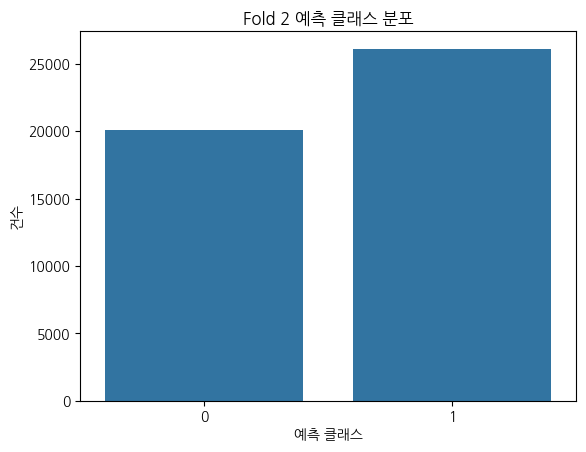


[Fold 3] 정확도: 0.5530, Macro F1: 0.5482
              precision    recall  f1-score   support

           0     0.7787    0.4814    0.5950     31510
           1     0.3886    0.7066    0.5014     14697

    accuracy                         0.5530     46207
   macro avg     0.5836    0.5940    0.5482     46207
weighted avg     0.6546    0.5530    0.5652     46207



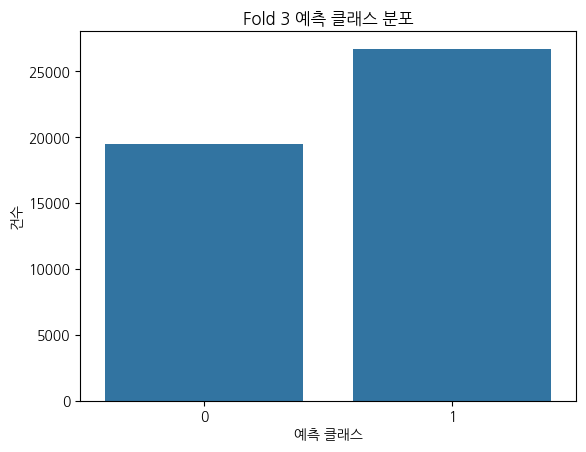


[Fold 4] 정확도: 0.5693, Macro F1: 0.5601
              precision    recall  f1-score   support

           0     0.7665    0.5260    0.6239     31377
           1     0.3973    0.6610    0.4963     14830

    accuracy                         0.5693     46207
   macro avg     0.5819    0.5935    0.5601     46207
weighted avg     0.6480    0.5693    0.5829     46207



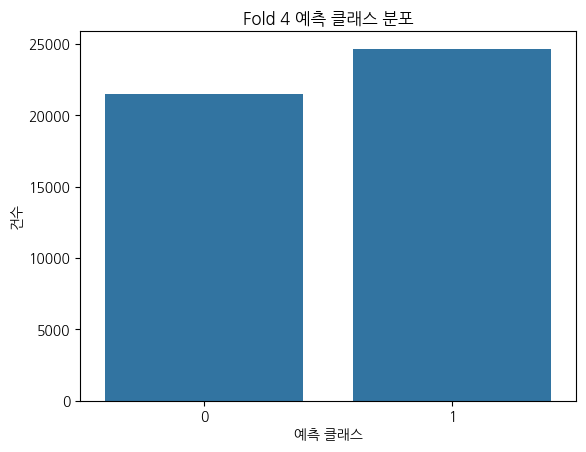


[Fold 5] 정확도: 0.5549, Macro F1: 0.5507
              precision    recall  f1-score   support

           0     0.7746    0.4816    0.5939     31234
           1     0.3956    0.7077    0.5075     14973

    accuracy                         0.5549     46207
   macro avg     0.5851    0.5946    0.5507     46207
weighted avg     0.6518    0.5549    0.5659     46207



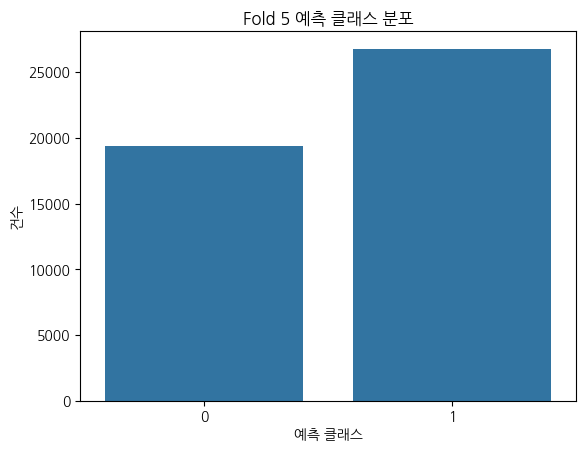

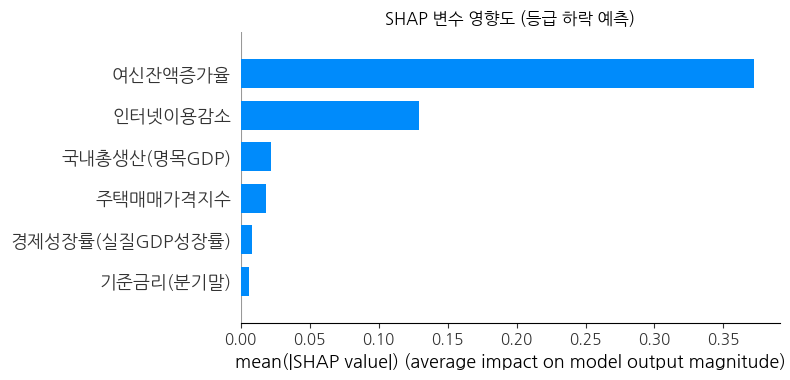

In [8]:
### 이번 달보다 다음 달에 고객의 등급이 하락하면 (=신용도 저하) → 리스크가 발생한 것으로 간주
### “여신 고객이 다음 달에 더 낮은 신용등급으로 분류될 가능성”을 사전에 예측

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import shap
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score
import warnings
warnings.filterwarnings("ignore")

# -------------------------
# 1. 데이터 로딩 및 외부변수 병합
# -------------------------

df = pd.read_csv("Data/최종 프로젝트/최종_데이터.csv", encoding="cp949")
external = pd.read_excel("Data/최종 프로젝트/외부변수.xlsx")

df["기준년월"] = pd.to_datetime(df["기준년월"].astype(str), format="%Y%m")

external_long = external.melt(id_vars=["외부변수"], var_name="분기", value_name="값")
external_pivot = external_long.pivot(index="분기", columns="외부변수", values="값").reset_index()

def quarter_to_date(q):
    year = q[:4]
    quarter = q[4:].split("/")[0]
    month = {"1": "03", "2": "06", "3": "09", "4": "12"}[quarter]
    return pd.to_datetime(f"{year}{month}", format="%Y%m")

external_pivot["기준년월"] = external_pivot["분기"].apply(quarter_to_date)

df = pd.merge_asof(
    df.sort_values("기준년월"),
    external_pivot.sort_values("기준년월"),
    on="기준년월",
    direction="backward"
)

# -------------------------
# 2. 타깃 정의: 고객등급 하락 여부
# -------------------------

grade_map = {"최우수": 0, "우수": 1, "일반": 2}
df["고객등급코드"] = df["법인_고객등급"].map(grade_map)
df = df.sort_values("기준년월")
df["연체여부"] = (df["고객등급코드"].shift(-1) > df["고객등급코드"]).astype(int)

# -------------------------
# 3. 파생변수 생성
# -------------------------

df["여신잔액증가율"] = df["여신_운전자금대출잔액"].pct_change()
df["인터넷이용감소"] = (df["인터넷뱅킹거래금액"].diff() < 0).astype(int)

# -------------------------
# 4. 모델 입력 변수 정의
# -------------------------

feature_cols = [
    "경제성장률(실질GDP성장률)", 
    "국내총생산(명목GDP)", 
    "기준금리(분기말)",
    "주택매매가격지수",
    "여신잔액증가율",
    "인터넷이용감소"
]

df_model = df.dropna(subset=feature_cols + ["연체여부"])
X_raw = df_model[feature_cols]
y = df_model["연체여부"].values

# 쉼표 제거 및 float 변환
for col in feature_cols:
    X_raw[col] = X_raw[col].astype(str).str.replace(",", "").astype(float)

# inf/NaN 제거
X_raw.replace([np.inf, -np.inf], np.nan, inplace=True)
X_raw.dropna(inplace=True)

# y 재정렬 (X_raw와 인덱스 맞춤)
y = df_model.loc[X_raw.index, "연체여부"].values

# 정규화
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X_raw), columns=feature_cols)


# -------------------------
# 5. XGBoost + TimeSeriesSplit 학습
# -------------------------

tscv = TimeSeriesSplit(n_splits=5)
acc_list, f1_list = [], []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    neg, pos = np.bincount(y_train)
    scale_pos_weight = neg / pos if pos != 0 else 1

    model = xgb.XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='macro')
    acc_list.append(acc)
    f1_list.append(f1)

    print(f"\n[Fold {fold+1}] 정확도: {acc:.4f}, Macro F1: {f1:.4f}")
    print(classification_report(y_test, preds, digits=4))

    sns.countplot(x=preds)
    plt.title(f"Fold {fold+1} 예측 클래스 분포")
    plt.xlabel("예측 클래스")
    plt.ylabel("건수")
    plt.show()

# -------------------------
# 6. SHAP 변수 영향도 분석
# -------------------------

explainer = shap.Explainer(model, X)
sample_idx = np.random.choice(X.shape[0], size=min(500, X.shape[0]), replace=False)
shap_values = explainer(X.iloc[sample_idx])

shap.summary_plot(shap_values, X.iloc[sample_idx], plot_type="bar", show=False)
plt.title("SHAP 변수 영향도 (등급 하락 예측)")
plt.tight_layout()
plt.show()

In [10]:
### 고객등급코드 (0=최우수, 1=우수, 2=일반)를 연체위험의 수치적 대리변수로 설정하여 예측


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import shap
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

# -------------------------
# 1. 데이터 불러오기
# -------------------------

# 기본 고객 데이터
df = pd.read_csv("Data/최종 프로젝트/최종_데이터.csv", encoding="cp949")
df["기준년월"] = pd.to_datetime(df["기준년월"].astype(str), format="%Y%m")

# 외부/파생 변수
external = pd.read_excel("Data/최종 프로젝트/2단계_파생변수포함.xlsx")
external["기준년월"] = pd.to_datetime(external["기준분기"].astype(str), format="%Y%m")

# 기준년월 기준 병합
df = pd.merge(df, external, on="기준년월", how="left")

# -------------------------
# 2. 타깃 변수 정의
# -------------------------
grade_map = {"최우수": 0, "우수": 1, "일반": 2}
df["고객등급코드"] = df["법인_고객등급"].map(grade_map)

# -------------------------
# 3. 입력 변수 정의
# -------------------------
# 엑셀에 포함된 파생 및 외부 변수 기반 (열 이름에 따라 수정 필요)
feature_cols = [
    "기준금리", "DSR", "LTV", "주택가격지수", "인터넷은행점유율",
    "ESG지수", "대출승인율", 
    "여신잔액증가율", "출금변화율", "인터넷이용감소", "활동감소"
]
target_col = "고객등급코드"

df_model = df.dropna(subset=feature_cols + [target_col])
X_raw = df_model[feature_cols]
y = df_model[target_col]

# -------------------------
# 4. 전처리
# -------------------------
# 쉼표 제거 후 float 변환
for col in feature_cols:
    X_raw[col] = X_raw[col].astype(str).str.replace(",", "").astype(float)

X_raw.replace([np.inf, -np.inf], np.nan, inplace=True)
X_raw.dropna(inplace=True)
y = y[X_raw.index]

# 정규화
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X_raw), columns=feature_cols)

# -------------------------
# 5. XGBoost 회귀 학습
# -------------------------
tscv = TimeSeriesSplit(n_splits=5)
rmse_list, r2_list = [], []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1.0,
        reg_lambda=1.0,
        random_state=42
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    rmse_list.append(rmse)
    r2_list.append(r2)

    print(f"[Fold {fold+1}] RMSE: {rmse:.4f}, R²: {r2:.4f}")

# -------------------------
# 6. SHAP 변수 중요도 분석
# -------------------------
explainer = shap.Explainer(model, X)
sample_idx = np.random.choice(X.shape[0], size=min(500, X.shape[0]), replace=False)
shap_values = explainer(X.iloc[sample_idx])

shap.summary_plot(shap_values, X.iloc[sample_idx], plot_type="bar", show=False)
plt.title("SHAP 변수 영향도 (고객등급 예측)")
plt.tight_layout()
plt.show()

ValueError: time data "2015-04-01" doesn't match format "%Y%m", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
지금 이 분석이 무엇을 했고, 이 분석을 통해 얻은 인사이트가 뭐지? 정확하고 구체적이게 설명

In [17]:
external

,Unnamed: 0,기준분기,총자산순이익률(ROA),자기자본순이익률(ROE),원화예대금리차,총대출채권_연체율,기업대출_연체율,대기업대출_연체율,중소기업대출_연체율,개인사업자_연체율,...,총대출채권_연체율_yoy,예대 스프레드_diff,예대 스프레드_yoy,기준금리_diff,기준금리_yoy,가계대출증가율,가계대출증가율_diff,총예금증가율,총예금증가율_diff,요구불예금비중_diff
0,0,2015-04-01,0.39,5.27,1.90,0.56,0.67,0.15,0.77,0.49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2015-07-01,0.39,5.27,1.82,0.47,0.50,0.11,0.58,0.40,...,NaN,-0.036667,NaN,-0.249389,NaN,NaN,NaN,NaN,NaN,0.008114
2,2,2015-10-01,0.39,5.27,1.81,0.43,0.47,0.04,0.56,0.36,...,NaN,0.143333,NaN,-0.195055,NaN,NaN,NaN,NaN,NaN,0.007590
3,3,2016-01-01,0.39,5.27,1.79,0.38,0.43,0.06,0.50,0.27,...,NaN,-0.093333,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.002518
4,4,2016-04-01,0.33,4.18,1.76,0.45,0.57,0.49,0.59,0.30,...,-0.196429,0.103333,0.065789,0.000000,-0.228571,0.049571,NaN,-0.034000,NaN,0.015422
5,5,2016-07-01,0.33,4.18,1.77,0.40,0.51,0.63,0.49,0.29,...,-0.148936,-0.003333,0.086372,-0.060440,-0.150729,0.105598,0.056027,-0.019898,0.014102,0.002221
6,6,2016-10-01,0.33,4.18,1.77,0.38,0.48,0.64,0.45,0.27,...,-0.116279,0.030000,0.019504,-0.189560,-0.166667,0.088051,-0.017547,-0.007899,0.011999,0.002219
7,7,2017-01-01,0.33,4.18,1.78,0.33,0.43,0.65,0.39,0.25,...,-0.131579,-0.046667,0.046642,0.000000,-0.166667,0.068156,-0.019895,-0.005012,0.002887,0.001950
8,8,2017-04-01,0.73,9.22,1.88,0.36,0.48,0.80,0.42,0.24,...,-0.200000,0.113333,0.049383,0.000000,-0.166667,0.042953,-0.025203,0.007984,0.012996,0.007739
9,9,2017-07-01,0.73,9.22,1.92,0.30,0.36,0.27,0.38,0.25,...,-0.250000,-0.030000,0.035336,0.000000,-0.131679,0.036405,-0.006548,-0.000650,-0.008634,0.003187


In [14]:
external.columns

Index(['외부변수', '20141/4', '20142/4', '20143/4', '20144/4', '20151/4',
       '20152/4', '20153/4', '20154/4', '20161/4', '20162/4', '20163/4',
       '20164/4', '20171/4', '20172/4', '20173/4', '20174/4', '20181/4',
       '20182/4', '20183/4', '20184/4', '20191/4', '20192/4', '20193/4',
       '20194/4', '20201/4', '20202/4', '20203/4', '20204/4', '20211/4',
       '20212/4', '20213/4', '20214/4', '20221/4', '20222/4', '20223/4',
       '20224/4', '20231/4', '20232/4', '20233/4', '20234/4', '20241/4',
       '20242/4', '20243/4', '20244/4'],
      dtype='object')